In [1]:
!nvidia-smi
!python -V

# Stable pins for Kaggle (Python 3.10) that work with PyCaret 3.3.x
!pip -q install -U pip setuptools wheel
!pip -q install "pycaret==3.3.2" "gradio>=4,<5"

# sanity import
import sys, pycaret
print("Python:", sys.version.split()[0], "| PyCaret:", pycaret.__version__)


Thu Oct 23 06:55:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import io, zipfile, requests, pandas as pd

URL = "https://archive.ics.uci.edu/static/public/222/bank+marketing.zip"

# download outer zip
outer = zipfile.ZipFile(io.BytesIO(requests.get(URL, timeout=60).content))

# choose inner zip with the richer dataset
inner_name = [n for n in outer.namelist() if n.endswith("bank-additional.zip")][0]
inner = zipfile.ZipFile(io.BytesIO(outer.read(inner_name)))

# load the full CSV from the inner zip
csv_name = [n for n in inner.namelist() if n.endswith("bank-additional/bank-additional-full.csv")][0]
with inner.open(csv_name) as f:
    df = pd.read_csv(f, sep=';')

df.head(), df.shape


(   age        job  marital    education  default housing loan    contact  \
 0   56  housemaid  married     basic.4y       no      no   no  telephone   
 1   57   services  married  high.school  unknown      no   no  telephone   
 2   37   services  married  high.school       no     yes   no  telephone   
 3   40     admin.  married     basic.6y       no      no   no  telephone   
 4   56   services  married  high.school       no      no  yes  telephone   
 
   month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
 0   may         mon  ...         1    999         0  nonexistent          1.1   
 1   may         mon  ...         1    999         0  nonexistent          1.1   
 2   may         mon  ...         1    999         0  nonexistent          1.1   
 3   may         mon  ...         1    999         0  nonexistent          1.1   
 4   may         mon  ...         1    999         0  nonexistent          1.1   
 
    cons.price.idx  cons.conf.idx  euribor

In [3]:
print(df.dtypes.head(12))
print("Target distribution:\n", df['y'].value_counts())

# Ensure target is string labels
df['y'] = df['y'].astype(str)
print("Data ready — shape:", df.shape)


age             int64
job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
duration        int64
campaign        int64
dtype: object
Target distribution:
 y
no     36548
yes     4640
Name: count, dtype: int64
Data ready — shape: (41188, 21)


In [4]:
from pycaret.classification import *

s = setup(
    data=df,
    target="y",
    session_id=42,
    use_gpu=True,          # GPU where available
    normalize=True,
    fix_imbalance=True,    # handle class imbalance
    fold=5,
    log_experiment=False,
    verbose=False
)

# Compare and select top 3 models by F1
top3 = compare_models(n_select=3, sort="F1")

# Tune each of the top 3
tuned = [tune_model(m, optimize="F1") for m in top3]

# Blend tuned models
blended = blend_models(tuned, optimize="F1")

# Let automl pick the best overall
best = automl(optimize="F1")
best


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9157,0.9469,0.9157,0.9097,0.9119,0.5412,0.5448,34.7580
lightgbm,Light Gradient Boosting Machine,0.9137,0.9471,0.9137,0.9096,0.9113,0.5450,0.5464,2.8220
gbc,Gradient Boosting Classifier,0.9087,0.9411,0.9087,0.9091,0.9089,0.5453,0.5454,19.4520
xgboost,Extreme Gradient Boosting,0.9100,0.9434,0.9100,0.9057,0.9075,0.5256,0.5271,1.4720
ada,Ada Boost Classifier,0.9054,0.9287,0.9054,0.9010,0.9030,0.5029,0.5040,4.8120
et,Extra Trees Classifier,0.8993,0.9163,0.8993,0.8864,0.8903,0.4110,0.4212,2.8060
dt,Decision Tree Classifier,0.8862,0.7309,0.8862,0.8897,0.8878,0.4476,0.4481,1.5960
lda,Linear Discriminant Analysis,0.8654,0.9299,0.8654,0.9164,0.8817,0.5102,0.5449,1.0200
lr,Logistic Regression,0.8619,0.9358,0.8619,0.9215,0.8800,0.5164,0.5601,1.5980
svm,SVM - Linear Kernel,0.8444,0.0000,0.8444,0.9199,0.8669,0.4850,0.5390,12.2180


[2025-10-23 06:59:02.365] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9166,0.9443,0.9166,0.9112,0.9132,0.5501,0.5529
1,0.9185,0.9496,0.9185,0.9162,0.9172,0.5795,0.5800
2,0.9122,0.9435,0.9122,0.9097,0.9109,0.5473,0.5478
3,0.9086,0.9396,0.9086,0.9041,0.9061,0.5182,0.5195
4,0.9143,0.9463,0.9143,0.9119,0.9130,0.5587,0.5591
Mean,0.9141,0.9447,0.9141,0.9106,0.9121,0.5508,0.5519
Std,0.0034,0.0033,0.0034,0.0039,0.0036,0.0198,0.0195


Fitting 5 folds for each of 10 candidates, totalling 50 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9156,0.9465,0.9156,0.9093,0.9116,0.5391,0.5429
1,0.9197,0.9503,0.9197,0.9154,0.9171,0.5725,0.5744
2,0.9159,0.9469,0.9159,0.9137,0.9147,0.5670,0.5674
3,0.9072,0.9398,0.9072,0.9029,0.9048,0.5123,0.5134
4,0.9171,0.9486,0.9171,0.9142,0.9155,0.5694,0.5701
Mean,0.9151,0.9464,0.9151,0.9111,0.9127,0.5521,0.5537
Std,0.0042,0.0036,0.0042,0.0046,0.0044,0.0232,0.0229


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Info] Number of positive: 20466, number of negative: 20466
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 14769
[LightGBM] [Info] Number of data points in the train set: 40932, number of used features: 6

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9130,0.9440,0.9130,0.9063,0.9087,0.5239,0.5278
1,0.9176,0.9481,0.9176,0.9134,0.9151,0.5633,0.5649
2,0.9117,0.9422,0.9117,0.9076,0.9094,0.5353,0.5365
3,0.9055,0.9390,0.9055,0.9004,0.9026,0.4989,0.5004
4,0.9135,0.9454,0.9135,0.9089,0.9108,0.5412,0.5429
Mean,0.9122,0.9437,0.9122,0.9073,0.9093,0.5325,0.5345
Std,0.0039,0.0031,0.0039,0.0042,0.0040,0.0211,0.0210


Fitting 5 folds for each of 10 candidates, totalling 50 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9169,0.9461,0.9169,0.9107,0.9129,0.5453,0.5495
1,0.9173,0.9507,0.9173,0.9133,0.9150,0.5633,0.5647
2,0.9143,0.9457,0.9143,0.9109,0.9124,0.5525,0.5534
3,0.9055,0.9407,0.9055,0.9004,0.9026,0.4989,0.5004
4,0.9180,0.9482,0.9180,0.9146,0.9161,0.5712,0.5722
Mean,0.9144,0.9463,0.9144,0.9100,0.9118,0.5462,0.5480
Std,0.0046,0.0033,0.0046,0.0050,0.0048,0.0253,0.0251


LGBMClassifier(bagging_fraction=0.6, bagging_freq=5, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, device='gpu',
               feature_fraction=0.8, importance_type='split',
               learning_rate=0.05, max_depth=-1, min_child_samples=86,
               min_child_weight=0.001, min_split_gain=0.9, n_estimators=130,
               n_jobs=-1, num_leaves=40, objective=None, random_state=42,
               reg_alpha=2, reg_lambda=0.001, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9186,0.9502,0.9186,0.9157,0.9170,0.5769,0.5776


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,prediction_label,prediction_score
9923,49,technician,divorced,unknown,no,no,no,telephone,jun,wed,...,0,nonexistent,1.4,94.464996,-41.799999,4.959,5228.100098,no,no,0.9976
3477,56,blue-collar,married,basic.9y,unknown,yes,no,telephone,may,thu,...,0,nonexistent,1.1,93.994003,-36.400002,4.860,5191.000000,no,no,0.9961
12077,35,technician,single,professional.course,no,no,no,telephone,jun,fri,...,0,nonexistent,1.4,94.464996,-41.799999,4.947,5228.100098,no,no,0.9715
1579,32,blue-collar,married,basic.9y,unknown,no,no,telephone,may,fri,...,0,nonexistent,1.1,93.994003,-36.400002,4.855,5191.000000,no,no,0.9959
39993,27,unknown,single,university.degree,no,yes,no,cellular,jun,wed,...,2,success,-1.7,94.055000,-39.799999,0.767,4991.600098,yes,yes,0.9167


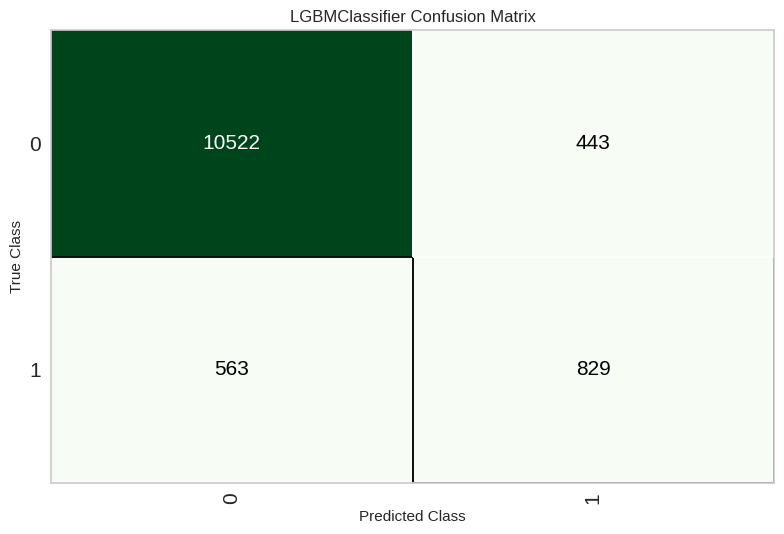

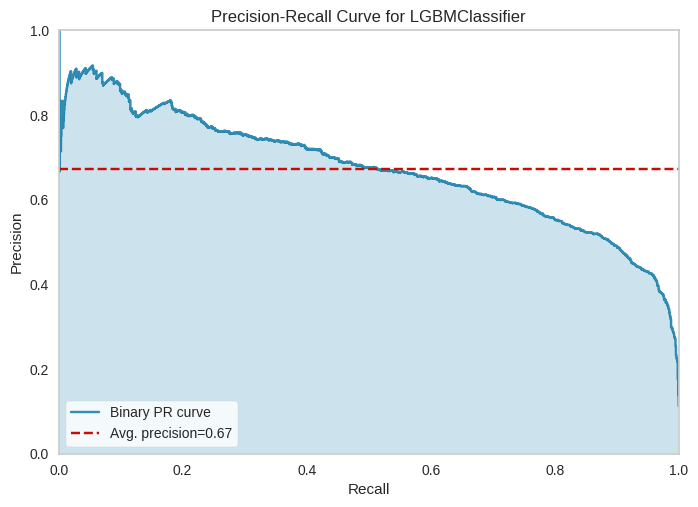

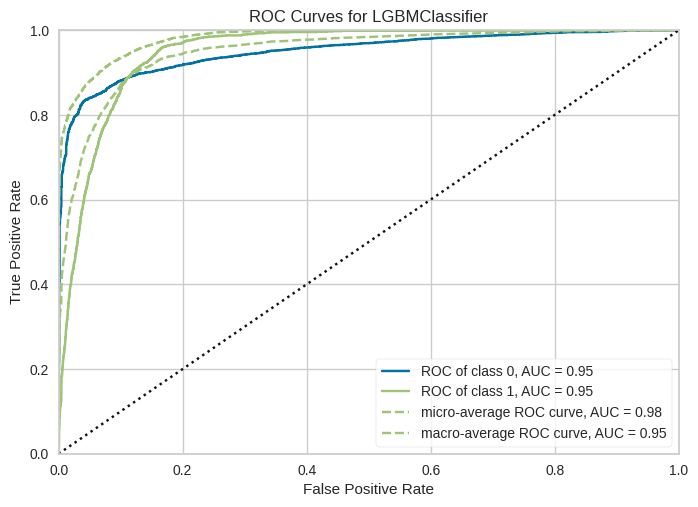

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['age', 'duration', 'campaign',
                                              'pdays', 'previous',
                                              'emp.var.rate', 'cons.price.idx',
                                              'cons.conf.idx', 'euribor3m',
                                              'nr.employed'],
                                     transformer=Simple...
                                 boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, device='gpu',
                                 feature_fraction=0.8, importance_type='split',
                                 lea

In [5]:
# Hold-out predictions
pred_holdout = predict_model(best)
display(pred_holdout.head())

# Key plots for your video
plot_model(best, plot="confusion_matrix")
plot_model(best, plot="pr")
plot_model(best, plot="auc")

# Save leaderboard + model
lb = pull()
import os
os.makedirs("/kaggle/working/media/figures", exist_ok=True)
os.makedirs("/kaggle/working/notebooks", exist_ok=True)

lb.to_csv("/kaggle/working/media/figures/binclf_leaderboard.csv", index=False)
save_model(best, "/kaggle/working/notebooks/binclf_final")
